In [53]:
import json
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

In [54]:
with open("GD-VCR/val.jsonl", "r") as f:
    records = [json.loads(line) for line in f]

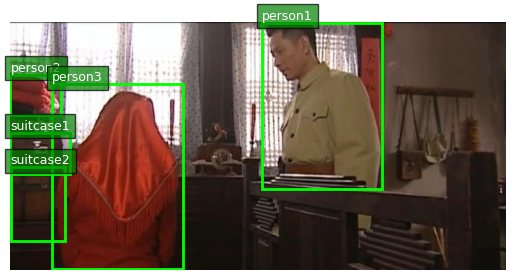

In [ ]:
# Pick a record
record = records[5]

img_path = record["img_fn"]
json_path = record["metadata_fn"]
labels = record["objects"]

# Load image and metadata
image = Image.open(img_path)
with open(json_path) as f:
    metadata = json.load(f)
boxes = metadata["boxes"]  # [[x1, y1, x2, y2, score], ...]

# Dictionary to keep label counters
label_counter = {}

# Plot
fig, ax = plt.subplots()
ax.imshow(image)

for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box[:4]
    label = labels[i] if i < len(labels) else "unknown"

    # Update counter and indexed label
    label_counter[label] = label_counter.get(label, 0) + 1
    indexed_label = f"{label}{label_counter[label]}"

    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=2, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, indexed_label, color='white',
            bbox=dict(facecolor='green', alpha=0.7), fontsize=9)

plt.axis('off')
plt.show()


In [56]:
def format_sequence(seq):
    """Helper function to flatten mixed text/token list (e.g., ["Rolling", "up", [2], "'s"] → 'Rolling up person3's')"""
    result = []
    for item in seq:
        if isinstance(item, list):
            result.append(f"person{item[0]+1}")  # +1 for 1-based indexing
        else:
            result.append(item)
    return ' '.join(result).replace(" 's", "'s").replace(" ,", ",").replace(" .", ".")

# Pick a record
record = records[5]

# Extract question and choices
question = format_sequence(record["question"])
choices = [format_sequence(choice) for choice in record["answer_choices"]]
correct_idx = record["answer_label"]
correct_answer = choices[correct_idx]

# Display
print("📌 Question:")
print(question)
print("\n🔢 Answer Choices:")
for i, choice in enumerate(choices):
    print(f"{i}. {choice}")

print(f"\n✅ Correct Answer: {correct_idx}. {correct_answer}")


📌 Question:
What are person1 going to participate in ?

🔢 Answer Choices:
0. They are college students and they are currently walking to class.
1. They are going to lifeboats on the sides of the ship.
2. They are going to have a wedding.
3. They will get in line with the others.

✅ Correct Answer: 2. They are going to have a wedding.


# EC-VCR

In [57]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# check version
print(detectron2.__version__)


0.6


In [58]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo

import cv2

# Load config and pretrained model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# Use COCO metadata (class names, colors, etc.)
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])  # COCO by default
class_names = metadata.thing_classes

predictor = DefaultPredictor(cfg)

[07/26 21:48:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


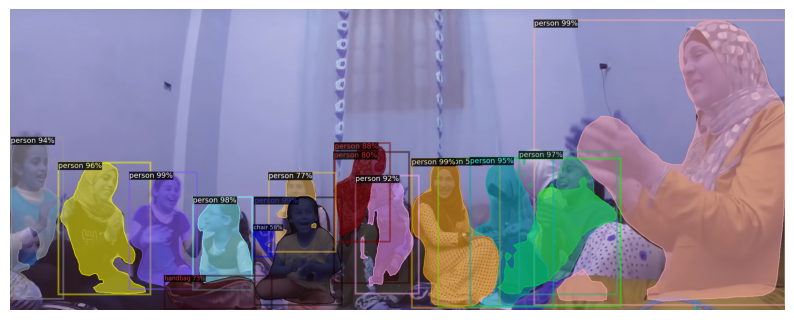

In [73]:
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
import json
import os
from pycocotools import mask as mask_utils
import numpy as np


def segment_image(img_path:str):
    segOutputs_file_path = img_path[:img_path.find('.')]+'.json'
    # Read an image
    image = cv2.imread(img_path)
    outputs = predictor(image)
    instances = outputs["instances"]
    boxes = instances.pred_boxes.tensor.cpu().numpy()
    classes = instances.pred_classes.cpu().numpy()
    masks = instances.pred_masks.cpu().numpy()

    # Prepare annotation
    height, width = image.shape[:2]
    scores = instances.scores.cpu().numpy()
    boxes_list = []
    for box, score in zip(boxes, scores):
        x1, y1, x2, y2 = map(float, box.tolist())  # ensure Python float
        boxes_list.append([x1, y1, x2, y2, float(score)])

    # Convert masks to polygons
    segms = []
    for mask in masks:
        encoded = mask_utils.encode(np.asfortranarray(mask.astype(np.uint8)))
        contours = mask_utils.decode(encoded).astype(np.uint8)
        polys = cv2.findContours(contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
        for poly in polys:
            segms.append([[p[0][0], p[0][1]] for p in poly])

    fixed_segms = []
    for poly in segms:
        fixed_poly = [[int(p[0]), int(p[1])] for p in poly]
        fixed_segms.append([fixed_poly])

    # Prepare final dictionary with native types
    output_dict = {
        "width": int(width),
        "height": int(height),
        "boxes": boxes_list,
        "objects": [class_names[i] for i in classes],
        "segms": fixed_segms
    }


    # Save as JSON
    with open(segOutputs_file_path, "w") as f:
        json.dump(output_dict, f, indent=2)


    return outputs

def visualize_segImg(img_path, segOutputs):
    image = cv2.imread(img_path)
    # Outputs contain 'instances' with boxes, classes, and masks
    instances = segOutputs["instances"]

    # Use COCO metadata (class names, colors, etc.)
    metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])  # COCO by default

    # Visualize predictions
    v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.0)
    out = v.draw_instance_predictions(instances.to("cpu"))

    # Show the result using matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()


img_id = 2 
visualize_segImg(f"EC-VCR/{img_id}.png", segment_image(f"EC-VCR/{img_id}.png"))


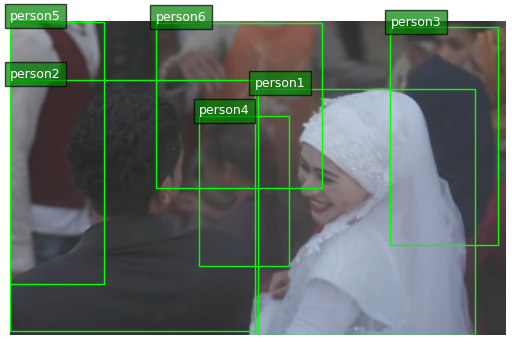

In [91]:
def visualize_img(img_path: str):
    json_path = img_path[:img_path.find('.')]+'.json'
    image = Image.open(img_path)
    with open(json_path) as f:
        metadata = json.load(f)
    labels = metadata['objects']
    boxes = metadata["boxes"]

    # Dictionary to keep label counters
    label_counter = {}

    # Plot
    fig, ax = plt.subplots()
    ax.imshow(image)

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box[:4]
        label = labels[i] if i < len(labels) else "unknown"

        # Update counter and indexed label
        label_counter[label] = label_counter.get(label, 0) + 1
        indexed_label = f"{label}{label_counter[label]}"

        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                linewidth=1, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, indexed_label, color='white',
                bbox=dict(facecolor='green', alpha=0.7), fontsize=9)

    plt.axis('off')
    plt.show()

visualize_img("EC-VCR/17.png")

In [64]:
import os
import re

# Folder path containing images
folder_path = "EC-VCR"

# Regex pattern to match filenames like "0.png", "1.png", etc.
pattern = re.compile(r'^\d+\.png$')

# List all files in the folder
all_files = sorted(os.listdir(folder_path))

# Filter images that do NOT match the "number.png" pattern
files_to_rename = [f for f in all_files if not pattern.match(f) and f.lower().endswith((".png", ".jpg", ".jpeg"))]


# Rename them to 0.png, 1.png, ...
for idx, old_name in enumerate(files_to_rename):
    new_name = f"{idx}.png"
    old_path = os.path.join(folder_path, old_name)
    new_path = os.path.join(folder_path, new_name)
    
    # Make sure you don't overwrite existing numbered files
    while os.path.exists(new_path):
        idx += 1
        new_name = f"{idx}.png"
        new_path = os.path.join(folder_path, new_name)

    os.rename(old_path, new_path)
    print(f"Renamed: {old_name} -> {new_name}")


Renamed: Screenshot from 2025-07-23 15-18-03.png -> 0.png
Renamed: Screenshot from 2025-07-23 15-19-58.png -> 1.png
Renamed: Screenshot from 2025-07-23 15-20-38.png -> 2.png
Renamed: Screenshot from 2025-07-23 15-21-02.png -> 3.png
Renamed: Screenshot from 2025-07-23 15-22-38.png -> 4.png
Renamed: Screenshot from 2025-07-23 15-23-24.png -> 5.png
Renamed: Screenshot from 2025-07-23 15-23-29.png -> 6.png
Renamed: Screenshot from 2025-07-23 15-24-58.png -> 7.png
Renamed: Screenshot from 2025-07-23 15-25-08.png -> 8.png
Renamed: Screenshot from 2025-07-23 15-25-18.png -> 9.png
Renamed: Screenshot from 2025-07-23 15-25-31.png -> 10.png
Renamed: Screenshot from 2025-07-23 15-25-55.png -> 11.png
Renamed: Screenshot from 2025-07-23 15-26-41.png -> 12.png
Renamed: Screenshot from 2025-07-23 15-27-13.png -> 13.png
Renamed: Screenshot from 2025-07-23 15-27-39.png -> 14.png
Renamed: Screenshot from 2025-07-23 15-28-05.png -> 15.png
Renamed: Screenshot from 2025-07-23 15-28-19.png -> 16.png
Renamed

In [71]:
for i in range(18):
    segment_image("EC-VCR/" + str(i) + '.png')